In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from patsy import dmatrices

import matplotlib.pyplot as plt
import seaborn as sns

# Problem współliniowości

### Diagnostyka

1. **Macierz korelacji predyktorów** - $D_X = (\rho_{ij})$;

    **Interpretacja:** Uwarunkowanie macierzy $\frac{\lambda_{\text{max}}(D_X)}{\lambda_{\text{min}}(D_X)}$ - duże $\implies$ istnieje para predyktorów zależnych liniowo;

3. **VIF** (ang. *variance inflation factor*) - współczynnik podbicia wariancji

    Dla $1\leq i \leq p-1$: $$R^2_i = \frac{\text{RSS}}{\text{TSS}}$$ dla modelu $x_i \sim x_{-i}$, gdzie $x_{-i}$ oznacza wszystkie zmienne objaśniające z  pominięciem $i$-tej.

    Wówczas
    $$
    \text{VIF}_i = \frac{1}{1-R_i^2}
    $$

    **Interpretacja:** Duża wartość dla pewnego $i$ wskazuje na potencjalną liniową zależność $i$-tej zmiennej objaśniającej od pozostałych zmiennych. 

    **Reguła kciuka:** Jeśli $\text{VIF}_i\geq 10$, to $i$-tą zmienną uznajemy w przybliżeniu liniowo zależną od pozostałych.

# Zadanie 1
Dla danych `Carseats` sprawdź, czy występuje w nich problem współliniowości przy użyciu powyższych metod. Jeśli tak, odrzuć ze zbioru zmienne zależne liniowo i dopasuj model regresji liniowej bez nich. Porównaj wyniki.

In [16]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)
carseats.data

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [17]:
Xvar = carseats.data.loc[:, ~carseats.data.columns.isin(['Sales'])]

correlation_matrix = Xvar.corr()
print(correlation_matrix)

features = Xvar.columns[[0, 1, 2, 3, 4, 6, 7]]

             CompPrice    Income  Advertising  Population     Price       Age  \
CompPrice     1.000000 -0.080653    -0.024199   -0.094707  0.584848 -0.100239   
Income       -0.080653  1.000000     0.058995   -0.007877 -0.056698 -0.004670   
Advertising  -0.024199  0.058995     1.000000    0.265652  0.044537 -0.004557   
Population   -0.094707 -0.007877     0.265652    1.000000 -0.012144 -0.042663   
Price         0.584848 -0.056698     0.044537   -0.012144  1.000000 -0.102177   
Age          -0.100239 -0.004670    -0.004557   -0.042663 -0.102177  1.000000   
Education     0.025197 -0.056855    -0.033594   -0.106378  0.011747  0.006488   

             Education  
CompPrice     0.025197  
Income       -0.056855  
Advertising  -0.033594  
Population   -0.106378  
Price         0.011747  
Age           0.006488  
Education     1.000000  


/tmp/ipykernel_130/4102777472.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = Xvar.corr()


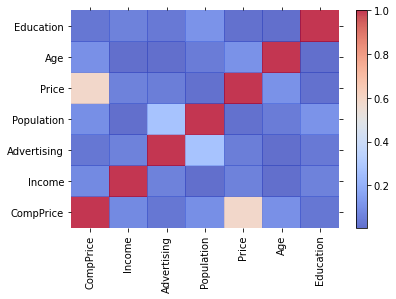

In [18]:
##zrobimy heatmapę dla wartości bezwzględnych: 0 = brak koralcji,  1 = mocna korelacja

import matplotlib as mpl

heatmap = plt.pcolor(np.abs(correlation_matrix), cmap=mpl.cm.coolwarm, alpha=0.8)

heatmap.axes.set_frame_on(False)

heatmap.axes.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5, minor=False)
heatmap.axes.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5, minor=False)
heatmap.axes.set_xticklabels(features, minor=False)
plt.xticks(rotation=90)

heatmap.axes.set_yticklabels(features, minor=False)

plt.tick_params(axis='both', which='both', bottom='off', 
                    top='off', left='off', right='off')
plt.colorbar()
plt.show()

In [19]:
# Vify

from statsmodels.stats.outliers_influence import variance_inflation_factor

columns = list(carseats.data.columns)
columns.remove('Sales')

features = "+".join(columns)
y, X = dmatrices('Sales ~'+features+"-1", data=carseats.data, return_type='dataframe')  # brak wyrazu wolnego (-1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif  # dla zmiennych ciągłych VIF < 10, więc brak silnej liniowej zależności pomiędzy zmiennymi

,VIF Factor,features
0,33.671155,ShelveLoc[Bad]
1,29.863368,ShelveLoc[Good]
2,75.283908,ShelveLoc[Medium]
3,1.022705,Urban[T.Yes]
4,1.980720,US[T.Yes]
5,1.554618,CompPrice
6,1.024731,Income
7,2.103136,Advertising
8,1.145534,Population
9,1.537068,Price


# Zadanie 2
Wczytaj dane `kc_house_data.csv` ([This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015](https://www.kaggle.com/harlfoxem/housesalesprediction/data)).

Dopasuj model `price ~ bathrooms + sqft_living + sqft_lot + sqft_above + sqft_basement + lat + long`, uwzględnij współliniowość predyktorów.

In [21]:
house = pd.read_csv('../../data/kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [22]:
columns = np.array(['bathrooms', 'sqft_living', 'sqft_lot',
                    'sqft_above', 'sqft_basement', 'lat', 'long'])

lm = smf.ols('price~' + "+".join(columns), data=house).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4975.
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        22:45:50   Log-Likelihood:            -2.9823e+05
No. Observations:               21613   AIC:                         5.965e+05
Df Residuals:                   21606   BIC:                         5.965e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.405e+07   1.59e+06    -46.635      0.000   -7.72e+07   -7.09e+07
bathrooms      3735.1592   3226.507      1.158      0.247   -2589.033    1.01e+04
sqft_living     182.5484      1.942     94.000      0.000     178.742     186.355
sqft_lot          0.1366      0.041      3.356      0.001       0.057       0.216
sqft_above      109.3906      2.015     54.299      0.000     105.442     113.339
sqft_basement    73.1581      2.620     27.919      0.000      68.022      78.294
lat            6.806e+05   1.19e+04     57.279      0.000    6.57e+05    7.04e+05
long          -3.405e+05   1.27e+04    -26.857      0.000   -3.65e+05   -3.16e+05
==============================================================================
Omnibus:                    16869.253   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           923207.453
Skew:                           3.300   Prob(JB):                         0.00
Kurtosis:                      34.331   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.62e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<AxesSubplot:>

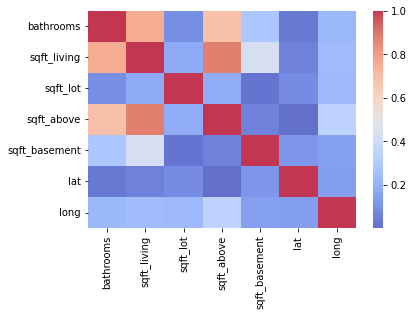

In [23]:
sns.heatmap(abs(house[columns].corr()), cmap=mpl.cm.coolwarm, alpha=0.8)

In [21]:
# #Vify

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(house[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif  # trzy zmienne są ze sobą perfekcyjnie powiązane (R^2 = 1)

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.005042e+01,bathrooms
1,inf,sqft_living
2,1.179803e+00,sqft_lot
3,inf,sqft_above
4,inf,sqft_basement
5,1.147556e+05,lat
6,1.145354e+05,long


In [22]:
lm_red = smf.ols('price~bathrooms+sqft_lot+sqft_above+sqft_basement+lat+long', data=house).fit()
lm_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4975.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        12:55:17   Log-Likelihood:            -2.9823e+05
No. Observations:               21613   AIC:                         5.965e+05
Df Residuals:                   21606   BIC:                         5.965e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.405e+07   1.59e+06    -46.635      0.000   -7.72e+07   -7.09e+07
bathrooms      3735.1592   3226.507      1.158      0.247   -2589.033    1.01e+04
sqft_lot          0.1366      0.041      3.356      0.001       0.057       0.216
sqft_above      291.9390      2.965     98.447      0.000     286.126     297.751
sqft_basement   255.7065      4.149     61.627      0.000     247.574     263.839
lat            6.806e+05   1.19e+04     57.279      0.000    6.57e+05    7.04e+05
long          -3.405e+05   1.27e+04    -26.857      0.000   -3.65e+05   -3.16e+05
==============================================================================
Omnibus:                    16869.253   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           923207.453
Skew:                           3.300   Prob(JB):                         0.00
Kurtosis:                      34.331   Cond. No.                     4.33e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
columns = ['bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(house[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif

,VIF Factor,features
0,20.050421,bathrooms
1,1.179803,sqft_lot
2,12.710522,sqft_above
3,1.791748,sqft_basement
4,114755.626015,lat
5,114535.443497,long


In [24]:
lm_red2 = smf.ols('price~bathrooms+sqft_lot+sqft_above+sqft_basement+long', data=house).fit()
lm_red2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     4614.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        12:58:53   Log-Likelihood:            -2.9975e+05
No. Observations:               21613   AIC:                         5.995e+05
Df Residuals:                   21607   BIC:                         5.996e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.196e+07   1.65e+06    -31.431      0.000   -5.52e+07   -4.87e+07
bathrooms       881.4780   3462.329      0.255      0.799   -5904.943    7667.899
sqft_lot         -0.0240      0.044     -0.550      0.582      -0.109       0.061
sqft_above      300.6646      3.178     94.598      0.000     294.435     306.894
sqft_basement   277.8804      4.434     62.675      0.000     269.190     286.571
long          -4.245e+05   1.35e+04    -31.408      0.000   -4.51e+05   -3.98e+05
==============================================================================
Omnibus:                    14211.786   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513412.003
Skew:                           2.652   Prob(JB):                         0.00
Kurtosis:                      26.281   Cond. No.                     4.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
columns = ['bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'long']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(house[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif

,VIF Factor,features
0,20.050421,bathrooms
1,1.179267,sqft_lot
2,12.598219,sqft_above
3,1.786517,sqft_basement
4,8.674776,long


In [26]:
lm_red3 = smf.ols('price~sqft_lot+sqft_above+sqft_basement+long', data=house).fit()
lm_red3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     5768.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        12:59:42   Log-Likelihood:            -2.9975e+05
No. Observations:               21613   AIC:                         5.995e+05
Df Residuals:                   21608   BIC:                         5.996e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.193e+07   1.65e+06    -31.476      0.000   -5.52e+07   -4.87e+07
sqft_lot         -0.0249      0.043     -0.573      0.567      -0.110       0.060
sqft_above      301.2365      2.248    133.975      0.000     296.829     305.644
sqft_basement   278.3821      3.971     70.096      0.000     270.598     286.166
long          -4.243e+05   1.35e+04    -31.451      0.000   -4.51e+05   -3.98e+05
==============================================================================
Omnibus:                    14208.662   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513034.687
Skew:                           2.651   Prob(JB):                         0.00
Kurtosis:                      26.272   Cond. No.                     4.19e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
columns = ['sqft_lot', 'sqft_above', 'sqft_basement', 'long']

vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(house[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif

,VIF Factor,features
0,1.173289,sqft_lot
1,5.871162,sqft_above
2,1.438995,sqft_basement
3,6.253636,long


# Zadanie 3
Wczytaj zbiór `Hald.csv`. Znajdź najlepszy model regresji liniowej uwzględniając współliniowość predyktorów.

Opis zbioru:

    Heat evolved during setting of 13 cement mixtures of four basic ingredients. Each ingredient percentage appears to be rounded down to a full integer. The sum of the four mixture percentages varies from a maximum of 99% to a minimum of 95%. If all four regressor X-variables always summed to 100%, the centered X-matrix would then be of rank only 3. Thus, the regression of heat on four X-percentages is ill-conditioned, with an approximate rank deficiency of MCAL = 1. The first column is the response and the remaining four columns are the predictors.

In [30]:
hald = pd.read_csv("../../data/Hald.csv")
hald.head()

,y,X1,X2,X3,X4
0,78.5,7,26,6,60
1,74.3,1,29,15,52
2,104.3,11,56,8,20
3,87.6,11,31,8,47
4,95.9,7,52,6,33


In [35]:
# model liniowy nie jest potrzebny do policzenia Vif (bo nie potrzebujemy uwzględniać zmiennej y)

lm = smf.ols('y~X1+X2+X3+X4', data=hald).fit()
lm.summary()

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     111.5
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.76e-07
Time:                        13:14:04   Log-Likelihood:                -26.918
No. Observations:                  13   AIC:                             63.84
Df Residuals:                       8   BIC:                             66.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.4054     70.071      0.891      0.399     -99.179     223.989
X1             1.5511      0.745      2.083      0.071      -0.166       3.269
X2             0.5102      0.724      0.705      0.501      -1.159       2.179
X3             0.1019      0.755      0.135      0.896      -1.638       1.842
X4            -0.1441      0.709     -0.203      0.844      -1.779       1.491
==============================================================================
Omnibus:                        0.165   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.320
Skew:                           0.201   Prob(JB):                        0.852
Kurtosis:                       2.345   Cond. No.                     6.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
columns = ["X1", "X2", "X3", "X4"]

vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(hald[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif

,VIF Factor,features
0,6.688643,X1
1,12.995434,X2
2,9.981159,X3
3,4.418264,X4


In [36]:
lm = smf.ols('y~X1+X3+X4', data=hald).fit()
lm.summary()

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     157.3
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.31e-08
Time:                        13:14:31   Log-Likelihood:                -27.310
No. Observations:                  13   AIC:                             62.62
Df Residuals:                       9   BIC:                             64.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    111.6844      4.562     24.479      0.000     101.363     122.005
X1             1.0519      0.224      4.702      0.001       0.546       1.558
X3            -0.4100      0.199     -2.058      0.070      -0.861       0.041
X4            -0.6428      0.045    -14.431      0.000      -0.744      -0.542
==============================================================================
Omnibus:                        0.353   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.468
Skew:                           0.064   Prob(JB):                        0.791
Kurtosis:                       2.080   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
columns = ["X1", "X3", "X4"]

vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(hald[columns].values, i) for i in range(len(columns))]
vif["features"] = columns
vif

,VIF Factor,features
0,1.670660,X1
1,2.638406,X3
2,3.402385,X4


# Obserwacje odstające

### Diagnostyka

Obserwacja odstająca (ang.outlier) jest obserwacją, która nie spełnia równania regresji czyli nie należy do modelu regresji. Obserwacje odstające mogą znacząco wpływać na postać prostej regresji.

**Rezyduum** $e_i$ przyjmuje dla $i$-tej obserwacji wartość różnicy:
$$
e_i = y_i - \hat{y}_i.
$$

**Błąd standardowy** takiego rezyduum $e_i$ jest równy:
$$
\text{SE}(e_i) = S\cdot\sqrt{1-h_i},
$$
gdzie 
- $S = \sigma$ oznacza przęciętne odchylenie wartości rzeczywistych od wartości przewidywanych,
- $h_i$ - wartość wpływu $i$-tej obserwacji, która wyraża się wzorem
$$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}
$$

Obserwacje odstajacę dzielimy na

   - **wpływowe** - obserwacja jest wpływowa jesli jej usuniecie z modelu ma duży wpływ na dopasowanie modelu/prognoze na podstawie modelu;
   - **niewpływowe** - obserwacja jest niewpływowa jesli jej usuniecie z modelu nie ma wpływu na dopasowanie modelu/prognoze na podstawie modelu;
  

  
### Detekcja obserwacji odstających:

1. **Wykres studentyzowanych rezyduów**

Dla małych prób, wartości zmiennej objaśniającej nie są w miarę równomiernie rozłożone i niektóre błędy $\text{SE}(e_i)$ mogą znacznie odbiegać od błędu $S$. Wówczas dobrze jest analizować rezydua przy użyciu tzw. **rezyduów studentyzowanych**.

$$r_i =\frac{e_i}{\text{SE}(e_i)}$$

To pozwoli wykrywać obserwacje faktycznie odstające, pomijając te, które przy analizie rezyduów $e_i$ sugerowały, że są odstające mimo, że takimi nie były. Dla rezyduów studentyzowanych zakłada się, że przy poziomie ufności równym 0.95 uznaje się je za normalne (zachowujące własność rozkładu normalnego), gdy należą do przedziału $[−2,+2]$.

Wykres studentyzowanych rezyduów względem ich indeksu identyfikuje duże wartości, które przypuszczalnie odpowiadają obserwacjom odstającym. Metoda ta nie sprawdzi się w sytuacji, gdy mamy w analizowanym zbiorze obserwację wpływową o małej wartości $e_i$. Wówczas bowiem nie określimy jej jako odstającej mimo, że taka w istocie jest.

2. **Wpływowość**

Wpływ $i$-tej obserwacji $h_i$ określamy wzorem
$$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2},
$$ 
który określa odstępstwo $x_i$ od $\overline{x}$.

Dla modelu o $p$ parametrach (gdzie $p$ to łączna liczba zmiennych objaśniających i objaśnianych), obserwację uznajemy za wpływową jeśli 
$$
h_i \geq \frac{2p}{n}.
$$

3. **Odległość Cooka**

Jest to miara stopnia zmiany współczynników regresji, gdyby dany przypadek pominąć w obliczeniach współczynników:
$$
D_i = \frac{\sum_{j=1}^n(\hat{Y}_j - \hat{Y}_{j(i)})^2}{pS^2},
$$
gdzie $\hat{Y}_j$ - prognoza na podstawie pełnych danych, $\hat{Y}_{j(i)}$ - prognoza bez $i$-tej obserwacji.

**Interpretacja**: Duża wartość $D_i$ wskazuje na znaczy wpływ usunięcia $i$-tej obserwacji, czyli $i$-ta obserwacja jest obserwacją wpływową.

Wszystkie wartości dla danej odległości powinny być tego samego rzędu. Jeśli tak nie jest, to prawdopodobnie dany przypadek ma istotnie duży wpływ na obciążenie równania regresji.

**Reguła kciuka**: $D_i > \frac{4}{(n − p − 1)}$

# Zadanie 4
Przeanalizuj obserwacje odstające w modelu `model` dla danych `Carseats`. Zidentyfikuj obserwacje im odpowiadające, usuń je ze zbioru i zbuduj model ponownie. Porównaj dopasowanie modeli. 
Analogicznie postępuj dla modelu `model2`.

In [38]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)
carseats_df = carseats.data

In [39]:
columns = list(carseats_df.columns)
columns.remove('Sales')

features = "+".join(columns)
print(features)

model = smf.ols('Sales~'+features, data=carseats_df)
fitted = model.fit()
fitted.summary()

CompPrice+Income+Advertising+Population+Price+ShelveLoc+Age+Education+Urban+US


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     243.4
Date:                Sun, 21 May 2023   Prob (F-statistic):          1.60e-166
Time:                        13:17:33   Log-Likelihood:                -568.99
No. Observations:                 400   AIC:                             1162.
Df Residuals:                     388   BIC:                             1210.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.6606      0.603      9.380      0.000       4.474       6.847
ShelveLoc[T.Good]       4.8502      0.153     31.678      0.000       4.549       5.151
ShelveLoc[T.Medium]     1.9567      0.126     15.516      0.000       1.709       2.205
Urban[T.Yes]            0.1229      0.113      1.088      0.277      -0.099       0.345
US[T.Yes]              -0.1841      0.150     -1.229      0.220      -0.479       0.111
CompPrice               0.0928      0.004     22.378      0.000       0.085       0.101
Income                  0.0158      0.002      8.565      0.000       0.012       0.019
Advertising             0.1231      0.011     11.066      0.000       0.101       0.145
Population              0.0002      0.000      0.561      0.575      -0.001       0.001
Price                  -0.0954      0.003    -35.700      0.000      -0.101      -0.090
Age                    -0.0460      0.003    -14.472      0.000      -0.052      -0.040
Education              -0.0211      0.020     -1.070      0.285      -0.060       0.018
==============================================================================
Omnibus:                        0.811   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.765
Skew:                           0.107   Prob(JB):                        0.682
Kurtosis:                       2.994   Cond. No.                     4.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
h = fitted.get_influence()
np.where(np.abs(h.resid_studentized) > 2)

(array([  0,  15,  34,  87,  92, 100, 171, 207, 247, 284, 297, 352, 356,
        357, 365, 375]),)

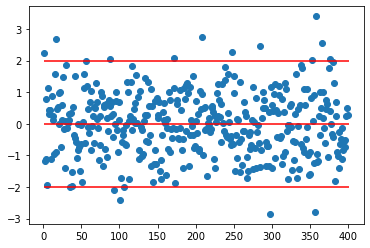

In [41]:
# wartości odstające (te poza pasem kwalifikujemy jako do usunięcia)

x = np.arange(1, h.resid_studentized.size + 1)
plt.scatter(x=x, y=h.resid_studentized)

plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=-2, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=0, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=2, color="r")

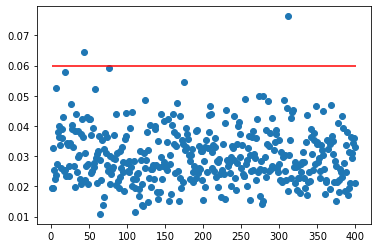

In [42]:
# wartości wpływowe h_i (są dwie obserwacje wpływowe)

h.hat_matrix_diag
threshold = 2 * h.exog.shape[1] / h.exog.shape[0]

x = np.arange(1, h.hat_matrix_diag.size + 1)
plt.scatter(x=x, y=h.hat_matrix_diag)

plt.hlines(xmin=1, xmax=h.hat_matrix_diag.size + 1, y=threshold, color="r")

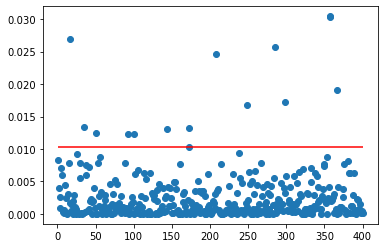

In [44]:
# obserwacje wpływowe odległości Cook'a (inna metoda detekcji wpływowości)

threshold = 4 / (h.exog.shape[0] - h.exog.shape[1] - 1)
print(h.cooks_distance)

x = np.arange(1, h.cooks_distance[0].size + 1)
plt.scatter(x=x, y=h.cooks_distance[0])

plt.hlines(xmin=1, xmax = x[-1], y=threshold, color='r')